In [1]:
# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    # Define the base path for your data directory for Colab
    basePath = '/content/drive/MyDrive'

else:
    # Running locally or in a different environment
    basePath = '..'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [15]:
df = pd.read_csv(f'{basePath}/data/processed/grouped_data2.csv')
only_req_cols = ['COUNTRY', 'DATE', 'TAVG', 'TMIN', 'TMAX', 'PRCP']
trimmed_df = df[only_req_cols].to_csv(f'{basePath}/data/processed/trimmedData.csv')

###**Essential Fns**

In [5]:
def filter_and_select_data(df, column_name, start_year):
    """Selects columns and filters data from a starting year."""
    selected_columns = ['COUNTRY', 'DATE', column_name]
    df_filtered = df[selected_columns].copy()
    return df_filtered[df_filtered['DATE'] >= start_year]

In [7]:
def get_sufficient_countries(df, column_name, completeness_threshold):
    """Returns a list of countries with data completeness >= a given threshold."""
    completeness = df.groupby('COUNTRY')[column_name].apply(lambda x: x.count() / len(x))
    return completeness[completeness >= completeness_threshold].index.tolist()

In [8]:
def split_data_by_year(df, train_end_year):
    """Splits a DataFrame into training and testing sets based on year."""
    df_train = df[df['DATE'] <= train_end_year].copy()
    df_test = df[df['DATE'] > train_end_year].copy()
    return df_train, df_test

In [12]:
def handle_missing_values(df, column_name):
    """Fills missing values in a DataFrame column using a sequence of
    interpolation, backfill, and forward fill, grouped by country.
    """
    df[column_name] = df.groupby('COUNTRY')[column_name].transform(lambda x: x.interpolate())
    df[column_name] = df.groupby('COUNTRY')[column_name].transform(lambda x: x.bfill())
    df[column_name] = df.groupby('COUNTRY')[column_name].transform(lambda x: x.ffill())
    return df

In [11]:
def ensure_consecutive_years(df, column_name, start_year, end_year=None):
    """
    Ensures a DataFrame has a complete time series of years for each country.
    Fills in missing years and interpolates data.
    """
    processed_dfs = []
    unique_countries = df['COUNTRY'].unique()
    for country in unique_countries:
        country_data = df[df['COUNTRY'] == country]
        if end_year is None:
            current_end_year = int(country_data['DATE'].max())
        else:
            current_end_year = end_year

        all_years = list(range(start_year, current_end_year + 1))
        country_years_df = pd.DataFrame({'COUNTRY': country, 'DATE': all_years})

        merged_country_df = pd.merge(country_years_df, country_data, on=['COUNTRY', 'DATE'], how='left')
        merged_country_df[column_name] = merged_country_df[column_name].interpolate()
        processed_dfs.append(merged_country_df)

    return pd.concat(processed_dfs, ignore_index=True)

In [14]:
def filter_by_common_countries(df_train, df_test, column_name):
    """
    Finds countries with at least one non-missing value in both training and
    testing DataFrames and filters both to include only those countries.

    Returns:
        tuple: A tuple containing the filtered training and testing DataFrames.
    """
    # Find countries in training data with at least one non-missing value
    countries_with_train_data = df_train.dropna(subset=[column_name])['COUNTRY'].unique()

    # Find countries in testing data with at least one non-missing value
    countries_with_test_data = df_test.dropna(subset=[column_name])['COUNTRY'].unique()

    # Find the intersection of these two lists
    common_countries = set(countries_with_train_data).intersection(set(countries_with_test_data))

    df_train_filtered = df_train[df_train['COUNTRY'].isin(common_countries)].copy()
    df_test_filtered = df_test[df_test['COUNTRY'].isin(common_countries)].copy()

    return df_train_filtered, df_test_filtered

In [13]:
def prepare_column_data_pipeline(df, column_name, start_year=1980, train_end_year=2010, completeness_threshold=0.8):
    """
    Main pipeline function to prepare and clean time series data for a specific column.
    """
    # Step 1: Filter and select data
    df_filtered = filter_and_select_data(df, column_name, start_year)

    # Step 2: Get a list of countries with sufficient data
    sufficient_countries = get_sufficient_countries(df_filtered, column_name, completeness_threshold)
    df_filtered = df_filtered[df_filtered['COUNTRY'].isin(sufficient_countries)].copy()

    # Step 3: Split into training and testing sets
    df_train, df_test = split_data_by_year(df_filtered, train_end_year)

    # Step 4: Handle missing values in both sets
    df_train = handle_missing_values(df_train, column_name)
    df_test = handle_missing_values(df_test, column_name)

    # Step 5: Find and filter for common countries (with non-missing data)
    # This is the corrected line
    df_train, df_test = filter_by_common_countries(df_train, df_test, column_name)

    # Step 6: Ensure a complete, consecutive time series
    df_train_completed = ensure_consecutive_years(df_train, column_name, start_year=start_year, end_year=train_end_year)
    df_test_completed = ensure_consecutive_years(df_test, column_name, start_year=train_end_year + 1)

    return df_train_completed, df_test_completed

###**Testing fns**

In [16]:
# Load the trimmed data
try:
    df = pd.read_csv(f'{basePath}/data/processed/trimmedData.csv')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("trimmedData.csv not found. Please ensure the path is correct and the file exists.")

# Now, let's use our new pipeline function to prepare the data for 'TAVG'
df_train_tavg, df_test_tavg = prepare_column_data_pipeline(df, column_name='TAVG')

# Display the head of the prepared DataFrames to get an initial look
print("\n--- Prepared Training Data (1980-2010) ---")
display(df_train_tavg.head())

print("\n--- Prepared Testing Data (2011 onwards) ---")
display(df_test_tavg.head())

# Perform a series of checks to verify the data preparation
print("\n--- Data Verification Checks ---")

# Check 1: No missing values in 'TAVG'
missing_train = df_train_tavg['TAVG'].isnull().sum()
missing_test = df_test_tavg['TAVG'].isnull().sum()
print(f"Missing values in training data 'TAVG': {missing_train}")
print(f"Missing values in testing data 'TAVG': {missing_test}")
assert missing_train == 0 and missing_test == 0, "Error: Missing values found!"
print("Check 1: No missing values confirmed.")

# Check 2: Correct year ranges
train_min_year = df_train_tavg['DATE'].min()
train_max_year = df_train_tavg['DATE'].max()
test_min_year = df_test_tavg['DATE'].min()
test_max_year = df_test_tavg['DATE'].max()
print(f"\nTraining data years: {train_min_year} to {train_max_year}")
print(f"Testing data years: {test_min_year} to {test_max_year}")
assert train_min_year == 1980 and train_max_year == 2010, "Error: Training year range is incorrect."
assert test_min_year == 2011 and test_max_year > 2011, "Error: Testing year range is incorrect."
print("Check 2: Year ranges are correct.")

# Check 3: Common countries in both sets
countries_train_set = set(df_train_tavg['COUNTRY'].unique())
countries_test_set = set(df_test_tavg['COUNTRY'].unique())
num_common_countries = len(countries_train_set.intersection(countries_test_set))
print(f"\nNumber of countries in training data: {len(countries_train_set)}")
print(f"Number of countries in testing data: {len(countries_test_set)}")
print(f"Number of common countries: {num_common_countries}")
assert countries_train_set == countries_test_set, "Error: Country sets are not the same!"
print("Check 3: Country sets are identical.")

# Check 4: Consecutive years for a sample country
sample_country = countries_train_set.pop() # Get one country for a check
train_dates = df_train_tavg[df_train_tavg['COUNTRY'] == sample_country]['DATE'].tolist()
test_dates = df_test_tavg[df_test_tavg['COUNTRY'] == sample_country]['DATE'].tolist()
expected_train_dates = list(range(1980, 2011))
expected_test_dates = list(range(2011, max(test_dates) + 1))
print(f"\nChecking consecutive years for country: {sample_country}")
assert train_dates == expected_train_dates, f"Error: Training years for {sample_country} are not consecutive."
assert test_dates == expected_test_dates, f"Error: Testing years for {sample_country} are not consecutive."
print(f"Check 4: Consecutive years confirmed for {sample_country}.")

print("\nAll data preparation checks passed successfully!")

DataFrame loaded successfully.

--- Prepared Training Data (1980-2010) ---


,COUNTRY,DATE,TAVG
0,American Samoa [United States],1980,27.1
1,American Samoa [United States],1981,26.8
2,American Samoa [United States],1982,27.0
3,American Samoa [United States],1983,27.0
4,American Samoa [United States],1984,27.0



--- Prepared Testing Data (2011 onwards) ---


,COUNTRY,DATE,TAVG
0,American Samoa [United States],2011,27.3
1,American Samoa [United States],2012,27.4
2,American Samoa [United States],2013,27.8
3,American Samoa [United States],2014,27.6
4,American Samoa [United States],2015,27.5



--- Data Verification Checks ---
Missing values in training data 'TAVG': 0
Missing values in testing data 'TAVG': 0
Check 1: No missing values confirmed.

Training data years: 1980 to 2010
Testing data years: 2011 to 2025
Check 2: Year ranges are correct.

Number of countries in training data: 36
Number of countries in testing data: 36
Number of common countries: 36
Check 3: Country sets are identical.

Checking consecutive years for country: Ukraine
Check 4: Consecutive years confirmed for Ukraine.

All data preparation checks passed successfully!


###**More functions**

In [19]:
def find_best_arima_order(time_series, arima_orders):
    """
    Finds the best ARIMA model order for a single time series based on AIC.

    Args:
        time_series (pd.Series): The time series data for a single country.
        arima_orders (list of tuples): A list of (p, d, q) orders to test.

    Returns:
        tuple: A tuple containing the best model fit object and its order.
               Returns (None, None) if no model can be fitted.
    """
    best_aic = np.inf
    best_order = None
    best_model_fit = None

    for order in arima_orders:
        try:
            model = ARIMA(time_series, order=order, freq='YS')
            model_fit = model.fit()

            # Get the AIC
            aic = model_fit.aic

            # Update best AIC and order if current model is better
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_model_fit = model_fit
                print(f"  Order: {order}, AIC: {aic}")

        except Exception as e:
            continue

    return best_model_fit, best_order

In [20]:
def train_models_for_countries(df, column_name, arima_orders):
    """
    Trains the best ARIMA model for each country in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing country data.
        column_name (str): The column containing the time series data.
        arima_orders (list of tuples): A list of (p, d, q) orders to test.

    Returns:
        dict: A dictionary where keys are country names and values are dictionaries
              containing the 'best_model' object and its 'best_order' and 'best_aic'.
    """
    best_arima_models = {}
    unique_countries = df['COUNTRY'].unique()

    for country in unique_countries:
        # Filter data for the current country
        country_data = df[df['COUNTRY'] == country]

        # Set the 'DATE' column as the index and convert it to a DatetimeIndex
        time_series = country_data.set_index(pd.to_datetime(country_data['DATE'], format='%Y'))[column_name]

        # Use the dedicated function to find the best model for this country
        best_model, best_order = find_best_arima_order(time_series, arima_orders)

        # Store the best model and its details
        if best_model is not None:
            best_arima_models[country] = {
                'best_model': best_model,
                'best_order': best_order,
                'best_aic': best_model.aic
            }
        else:
            print(f"Warning: No best model found for {country}. Skipping.")

    return best_arima_models

In [ ]:
# def save_trained_models(models_dict, models_dir):
#     """
#     Saves a dictionary of trained models to individual files in a specified directory.

#     Args:
#         models_dict (dict): A dictionary of trained model objects. Keys are country names.
#                             Values should contain the model object under the 'best_model' key.
#         models_dir (str): The directory path where the models should be saved.
#     """
#     # Create the directory if it doesn't exist
#     if not os.path.exists(models_dir):
#         os.makedirs(models_dir)
#         print(f"Created directory: {models_dir}")
#     else:
#         print(f"Directory already exists: {models_dir}")

#     # Iterate through the models dictionary and save each model
#     for country, model_info in models_dict.items():
#         best_model = model_info.get('best_model')

#         if best_model is not None:
#             # Create a clean filename from the country name
#             filename = f"{country.replace(' ', '_').replace('[', '').replace(']', '')}_arima_model.joblib"
#             filepath = os.path.join(models_dir, filename)

#             # Save the model object
#             joblib.dump(best_model, filepath)
#             print(f"Saved model for {country} to {filepath}")
#         else:
#             print(f"Warning: No model found for {country}, skipping save.")

#     print("\nAll available models have been saved.")

In [ ]:
def save_trained_models(models_dict, models_dir):
    """
    Saves a dictionary of trained models to individual files in a specified directory.

    #Most probably:
    Args:
        models_dict (dict): A dictionary of trained model objects. Keys are country names.
                            Values should contain the model object under the 'best_model' key.
        models_dir (str): The directory path where the models should be saved.
    """
    
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    for country, model_info in models_dict.items():
        best_model = model_info.get('best_model')

        if best_model is not None:
            # Create a filename by replacing spaces with underscores
            sanitized_country_name = country.replace(' ', '_')
            filename = f"{sanitized_country_name}_arima_model.joblib"
            filepath = os.path.join(models_dir, filename)

            joblib.dump(best_model, filepath)
        else:
            print(f"Warning: No model found for {country}, skipping save.")


###**Testing fns more**

In [29]:
# Assuming the data preparation functions are in the current environment
# (filter_and_select_data, etc.)

# Load the trimmed data
try:
    df = pd.read_csv(f'{basePath}/data/processed/trimmedData.csv')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("trimmedData.csv not found. Please ensure the path is correct and the file exists.")
    exit()
# Use the pipeline to get the cleaned training and testing data for 'TAVG'
df_train_tavg, df_test_tavg = prepare_column_data_pipeline(df, column_name='TAVG')

print("\nData prepared successfully.")

# Define a small set of ARIMA orders for a quick test
arima_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

print(f"Number of countries in training data: {len(df_train_tavg['COUNTRY'].unique())}")
print(f"Number of ARIMA orders to test: {len(arima_orders)}")

# --- TEST 1: TRAIN MODELS ---
print("\n--- TEST 1: Training Models ---")
trained_models = train_models_for_countries(df_train_tavg, 'TAVG', arima_orders)

# Check if the dictionary of models is not empty
print(f"Number of trained models returned: {len(trained_models)}")
assert len(trained_models) > 0, "Error: No models were trained!"

# Check if a model object is a valid ARIMAResultsWrapper
import statsmodels
sample_model = next(iter(trained_models.values()))['best_model']
assert isinstance(sample_model, statsmodels.tsa.arima.model.ARIMAResultsWrapper), "Error: Model object is not of the correct type!"

print("Training models test passed.")

# --- TEST 2: SAVE MODELS ---
print("\n--- TEST 2: Saving Models ---")

# Define a temporary directory for the test
test_models_dir = f'{basePath}/data/trained_test_models'
save_trained_models(trained_models, test_models_dir)

# Check if the directory was created and models were saved
assert os.path.exists(test_models_dir), "Error: Models directory was not created!"
num_files = len([name for name in os.listdir(test_models_dir) if os.path.isfile(os.path.join(test_models_dir, name))])
assert num_files == len(trained_models), "Error: Number of saved files does not match number of trained models!"

print("Saving models test passed.")

# Clean up the test directory
import shutil
shutil.rmtree(test_models_dir)
print(f"Cleaned up test directory: {test_models_dir}")

DataFrame loaded successfully.

Data prepared successfully.
Number of countries in training data: 36
Number of ARIMA orders to test: 3

--- TEST 1: Training Models ---
  Order: (1, 1, 0), AIC: 36.81667623928516
  Order: (0, 1, 1), AIC: 33.52777067930114


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: 144.0259021579367
  Order: (0, 1, 1), AIC: 142.61706355569643


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 37.55974182114888
  Order: (0, 1, 1), AIC: 29.582434457863712


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 96.02961116323979
  Order: (0, 1, 1), AIC: 93.52126156680893
  Order: (1, 1, 1), AIC: 93.35496074554769
  Order: (1, 1, 0), AIC: 104.77729641212633


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 97.58793036065532


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 27.425196118110147
  Order: (0, 1, 1), AIC: 23.327329990338505


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 71.85444863461417
  Order: (0, 1, 1), AIC: 70.2291719361505


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.64955906897213
  Order: (0, 1, 1), AIC: 42.86456908182223


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.44965709048114
  Order: (0, 1, 1), AIC: 88.0520419952615


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 86.7466361566713
  Order: (1, 1, 0), AIC: 2.417838917737722


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 1.5050247162418766


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.32542726213595
  Order: (0, 1, 1), AIC: 87.46291919361336


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 67.7806913952177
  Order: (0, 1, 1), AIC: 66.27554574388643


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 77.39849576476402
  Order: (0, 1, 1), AIC: 74.15156646838102


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 133.621835719703
  Order: (0, 1, 1), AIC: 132.21329721015644


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -9.513301748083277
  Order: (0, 1, 1), AIC: -11.68636287897273


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 81.14863788389884
  Order: (0, 1, 1), AIC: 76.5585681198091


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 54.781712326557766
  Order: (0, 1, 1), AIC: 50.50876142996167


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: 75.96811192128892
  Order: (0, 1, 1), AIC: 71.51044762853795


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 79.21678585397288


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 79.21378046717291


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 78.8573104040611
  Order: (1, 1, 0), AIC: 72.4760296654554
  Order: (0, 1, 1), AIC: 70.38199170512841


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: -17.388280969948326
  Order: (0, 1, 1), AIC: -18.661070466155493


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.43244271252955
  Order: (0, 1, 1), AIC: 72.84896107770044


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 83.67522957511859
  Order: (0, 1, 1), AIC: 79.66593292015196


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 78.54591029751049
  Order: (1, 1, 0), AIC: -3.4852532480156153


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -4.246809324062857


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 42.86103650062673
  Order: (0, 1, 1), AIC: 37.952903239743804


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 33.84644844250674
  Order: (0, 1, 1), AIC: 32.1457891009907


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 65.20128732520078
  Order: (0, 1, 1), AIC: 63.55494152199959


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 74.36014644108296
  Order: (0, 1, 1), AIC: 74.27944770054437


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 70.47210712440047
  Order: (1, 1, 0), AIC: 112.33346145422352
  Order: (0, 1, 1), AIC: 109.70629617955117


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/

  Order: (1, 1, 1), AIC: 107.58681703314716


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 107.30186153626715


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 96.76966163896967


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 108.8701654302375
  Order: (0, 1, 1), AIC: 108.15646198109249


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 105.90668299356808
  Order: (1, 1, 0), AIC: 66.32648920386188


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/

  Order: (1, 1, 0), AIC: 69.21650372467542
  Order: (0, 1, 1), AIC: 61.16777272383197


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 87.9480758122595


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 84.47594258476781


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 43.627291074521615


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 43.33975937286588


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 43.11090951923011


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 40.87220665809213


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 35.42170387896854


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Number of trained models returned: 36
Training models test passed.

--- TEST 2: Saving Models ---
/n/n/n/n  In save_Model_fn  /n/n/
Sanitized name is: American_Samoa_[United_States]
saved it as: ../data/trained_test_models/American_Samoa_[United_States]_arima_model.joblib
Sanitized name is: Antarctica
saved it as: ../data/trained_test_models/Antarctica_arima_model.joblib
Sanitized name is: Australia
saved it as: ../data/trained_test_models/Australia_arima_model.joblib
Sanitized name is: Austria
saved it as: ../data/trained_test_models/Austria_arima_model.joblib
Sanitized name is: Canada
saved it as: ../data/trained_test_models/Canada_arima_model.joblib
Sanitized name is: China
saved it as: ../data/trained_test_models/China_arima_model.joblib
Sanitized name is: Croatia
saved it as: ../data/trained_test_models/Croatia_arima_model.joblib
Sanitized name is: Cyprus
saved it as: ../data/trained_test_models/Cyprus_arima_model.joblib
Sanitized name is: Estonia
saved it as: ../data/trained_test

###**Prediction and Errors**

In [ ]:
# def load_trained_models(models_dir):
#     """
#     Loads all trained ARIMA model objects from a specified directory.

#     Args:
#         models_dir (str): The directory path where the models are saved.

#     Returns:
#         dict: A dictionary where keys are country names and values are the loaded
#               ARIMAResultsWrapper model objects. Returns an empty dictionary if
#               the directory does not exist or contains no models.
#     """
#     loaded_models = {}

#     if not os.path.exists(models_dir):
#         print(f"Directory not found: {models_dir}")
#         return loaded_models

#     # Loop through all files in the directory
#     for filename in os.listdir(models_dir):
#         if filename.endswith('_arima_model.joblib'):
#             filepath = os.path.join(models_dir, filename)
#             try:
#                 # Extract the country name from the filename
#                 country = filename.replace('_arima_model.joblib', '').replace('_', ' ')

#                 # Load the model object
#                 model = joblib.load(filepath)
#                 loaded_models[country] = model
#             except Exception as e:
#                 print(f"Warning: Could not load model from {filepath}. Error: {e}")

#     if not loaded_models:
#         print(f"No models found in directory: {models_dir}")
#     else:
#         print(f"Successfully loaded {len(loaded_models)} models.")

#     return loaded_models

In [ ]:
def load_trained_models(models_dir):
    """
    Loads all trained ARIMA model objects from a specified directory.
    """
    loaded_models = {}

    if not os.path.exists(models_dir):
        print(f"Directory not found: {models_dir}")
        return loaded_models

    for filename in os.listdir(models_dir):
        if filename.endswith('_arima_model.joblib'):
            filepath = os.path.join(models_dir, filename)
            try:
                # The key in our dictionary will be the sanitized name
                sanitized_country_name = filename.replace('_arima_model.joblib', '')

                model = joblib.load(filepath)
                loaded_models[sanitized_country_name] = model
            except Exception as e:
                print(f"Warning: Could not load model from {filepath}. Error: {e}")

    if not loaded_models:
        print(f"No models found in directory: {models_dir}")
    else:
        print(f"Successfully loaded {len(loaded_models)} models.")

    return loaded_models

In [ ]:
# def predict_single_country(model, start_year, end_year):
#     """
#     Generates predictions for a single country using a trained ARIMA model.

#     Args:
#         model: A trained ARIMAResultsWrapper model object.
#         start_year (int): The starting year for the prediction period.
#         end_year (int): The ending year for the prediction period.

#     Returns:
#         pd.Series: A Series of predicted values with a DatetimeIndex.
#     """
#     # The start and end years should be converted to a string format that
#     # statsmodels can understand for its DatetimeIndex
#     start_date = str(start_year)
#     end_date = str(end_year)

#     predictions = model.predict(start=start_date, end=end_date)
#     return predictions

In [31]:
def predict_single_country(model, df_train_len, df_test_len):
    """
    Generates predictions for a single country using a trained ARIMA model and integer offsets.
    """
    start_offset = df_train_len
    end_offset = df_train_len + df_test_len - 1
    predictions = model.predict(start=start_offset, end=end_offset)
    return predictions

In [32]:
def evaluate_single_country(actual_data, predictions):
    """
    Calculates key error metrics for a single country's predictions.

    Args:
        actual_data (pd.Series): The actual time series data.
        predictions (pd.Series): The predicted time series data.

    Returns:
        dict: A dictionary of calculated error metrics (MSE, RMSE, MAE).
    """
    mse = mean_squared_error(actual_data, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual_data, predictions)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

In [ ]:
# def predict_and_evaluate_all_models(models_dir, df_test, column_name):
#     """
#     Orchestrates the prediction and evaluation process for all countries.

#     Args:
#         models_dir (str): The directory containing the saved trained models.
#         df_test (pd.DataFrame): The cleaned DataFrame with testing data.
#         column_name (str): The name of the column to predict.

#     Returns:
#         dict: A dictionary where keys are country names and values are their
#               calculated error metrics.
#     """
#     all_country_errors = {}

#     # Load the models using our modular function
#     loaded_models = load_trained_models(models_dir)

#     if not loaded_models:
#         print("No models were loaded. Cannot proceed with prediction.")
#         return all_country_errors

#     print("\nStarting prediction and evaluation...")

#     # Loop through each country for which we have a trained model
#     for country, model in loaded_models.items():
#         # Get actual data for this country from the test set
#         country_test_data = df_test[df_test['COUNTRY'] == country].copy()

#         # Ensure the test data has a proper DatetimeIndex for alignment
#         country_test_data.set_index(pd.to_datetime(country_test_data['DATE'], format='%Y'), inplace=True)
#         actual_data = country_test_data[column_name]

#         # Get the start and end years for prediction from the actual data
#         start_year = actual_data.index.min().year
#         end_year = actual_data.index.max().year

#         try:
#             # Use our modular function to make predictions
#             predictions = predict_single_country(model, start_year, end_year)

#             # Use our modular function to evaluate the predictions
#             errors = evaluate_single_country(actual_data, predictions)

#             all_country_errors[country] = errors
#             print(f"Processed {country}: RMSE = {errors['RMSE']:.2f}, MAE = {errors['MAE']:.2f}")

#         except Exception as e:
#             print(f"Error processing {country}: {e}")

#     print("\nPrediction and evaluation complete.")
#     return all_country_errors

In [33]:
def predict_and_evaluate_all_models(models_dir, df_train, df_test, column_name):
    """
    Orchestrates the prediction and evaluation process for all countries.
    """
    all_country_errors = {}
    loaded_models = load_trained_models(models_dir)

    if not loaded_models:
        print("No models were loaded. Cannot proceed with prediction.")
        return all_country_errors

    print("\nStarting prediction and evaluation...")

    unique_countries = df_train['COUNTRY'].unique()

    for country in unique_countries:
        # Create the sanitized name to look up the model
        sanitized_country_name = country.replace(' ', '_')

        if sanitized_country_name not in loaded_models:
            print(f"Skipping {country}: No model found for sanitized name '{sanitized_country_name}'.")
            continue

        model = loaded_models[sanitized_country_name]

        # ... rest of the function logic is the same ...
        country_train_data = df_train[df_train['COUNTRY'] == country]
        country_test_data = df_test[df_test['COUNTRY'] == country]

        country_test_data.set_index(pd.to_datetime(country_test_data['DATE'], format='%Y'), inplace=True)
        actual_data = country_test_data[column_name]

        df_train_len = len(country_train_data)
        df_test_len = len(country_test_data)

        try:
            predictions = predict_single_country(model, df_train_len, df_test_len)

            predictions.index = actual_data.index

            errors = evaluate_single_country(actual_data, predictions)

            all_country_errors[country] = errors
            print(f"Processed {country}: RMSE = {errors['RMSE']:.2f}, MAE = {errors['MAE']:.2f}")

        except Exception as e:
            print(f"Error processing {country}: {e}")

    print("\nPrediction and evaluation complete.")
    return all_country_errors

###**Testing till now**

In [35]:
import shutil

# Assume all helper functions from previous steps are defined in the environment.
# (filter_and_select_data, get_sufficient_countries, split_data_by_year,
# handle_missing_values, filter_by_common_countries, ensure_consecutive_years,
# find_best_arima_order, train_models_for_countries, save_trained_models,
# load_trained_models, predict_single_country, evaluate_single_country,
# predict_and_evaluate_all_models)

# Define the file paths and parameters
data_file_path = f'{basePath}/data/processed/trimmedData.csv'
models_dir_path = f'{basePath}/data/trained_arima_models_test'
column_to_predict = 'TAVG'
arima_orders_test = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

print("--- Data Preparation ---")
try:
    df = pd.read_csv(data_file_path)
    df_train, df_test = prepare_column_data_pipeline(df, column_name=column_to_predict)
    print(f"Data prepared successfully. {len(df_train['COUNTRY'].unique())} countries in the training set.")
except Exception as e:
    print(f"Error during data preparation: {e}")
    exit()

print("\n--- Model Training ---")
try:
    trained_models_dict = train_models_for_countries(df_train, column_name=column_to_predict, arima_orders=arima_orders_test)
    print(f"Training complete. {len(trained_models_dict)} models were trained.")
except Exception as e:
    print(f"Error during model training: {e}")
    exit()

print("\n--- Model Saving ---")
try:
    # Clean up any existing test directory
    if os.path.exists(models_dir_path):
        shutil.rmtree(models_dir_path)
    save_trained_models(trained_models_dict, models_dir_path)
    print(f"Models saved to {models_dir_path}.")
except Exception as e:
    print(f"Error during model saving: {e}")
    exit()

print("\n--- Prediction and Evaluation ---")
try:
    # Run the full prediction and evaluation pipeline
    all_errors = predict_and_evaluate_all_models(models_dir_path, df_test, column_name=column_to_predict)

    if all_errors:
        print("\n--- Final Results ---")
        avg_rmse = np.mean([err['RMSE'] for err in all_errors.values()])
        avg_mae = np.mean([err['MAE'] for err in all_errors.values()])
        print(f"Average RMSE across all countries: {avg_rmse:.4f}")
        print(f"Average MAE across all countries: {avg_mae:.4f}")
    else:
        print("No errors could be calculated. The prediction pipeline might have failed.")
except Exception as e:
    print(f"Error during prediction and evaluation: {e}")

# Final cleanup
if os.path.exists(models_dir_path):
    shutil.rmtree(models_dir_path)
    print(f"\nCleaned up test directory: {models_dir_path}")

--- Data Preparation ---
Data prepared successfully. 36 countries in the training set.

--- Model Training ---
  Order: (1, 1, 0), AIC: 36.81667623928516


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 33.52777067930114


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 144.0259021579367
  Order: (0, 1, 1), AIC: 142.61706355569643


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 37.55974182114888
  Order: (0, 1, 1), AIC: 29.582434457863712


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 96.02961116323979
  Order: (0, 1, 1), AIC: 93.52126156680893


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 93.35496074554769


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 104.77729641212633


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 97.58793036065532


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 27.425196118110147


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 23.327329990338505


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 71.85444863461417


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 70.2291719361505


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.64955906897213
  Order: (0, 1, 1), AIC: 42.86456908182223


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.44965709048114
  Order: (0, 1, 1), AIC: 88.0520419952615


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 86.7466361566713


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 2.417838917737722


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 1.5050247162418766


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.32542726213595
  Order: (0, 1, 1), AIC: 87.46291919361336


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 67.7806913952177
  Order: (0, 1, 1), AIC: 66.27554574388643


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 77.39849576476402
  Order: (0, 1, 1), AIC: 74.15156646838102


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 133.621835719703


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 132.21329721015644


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -9.513301748083277
  Order: (0, 1, 1), AIC: -11.68636287897273


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 81.14863788389884
  Order: (0, 1, 1), AIC: 76.5585681198091


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 54.781712326557766
  Order: (0, 1, 1), AIC: 50.50876142996167


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.96811192128892


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 71.51044762853795


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 79.21678585397288
  Order: (0, 1, 1), AIC: 79.21378046717291


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 78.8573104040611
  Order: (1, 1, 0), AIC: 72.4760296654554
  Order: (0, 1, 1), AIC: 70.38199170512841


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: -17.388280969948326
  Order: (0, 1, 1), AIC: -18.661070466155493


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.43244271252955
  Order: (0, 1, 1), AIC: 72.84896107770044


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 83.67522957511859
  Order: (0, 1, 1), AIC: 79.66593292015196


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 78.54591029751049
  Order: (1, 1, 0), AIC: -3.4852532480156153


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -4.246809324062857


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 42.86103650062673
  Order: (0, 1, 1), AIC: 37.952903239743804


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 33.84644844250674
  Order: (0, 1, 1), AIC: 32.1457891009907


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 65.20128732520078
  Order: (0, 1, 1), AIC: 63.55494152199959


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 74.36014644108296
  Order: (0, 1, 1), AIC: 74.27944770054437


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 70.47210712440047
  Order: (1, 1, 0), AIC: 112.33346145422352


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 109.70629617955117


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 107.58681703314716
  Order: (1, 1, 0), AIC: 107.30186153626715


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 96.76966163896967


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 108.8701654302375
  Order: (0, 1, 1), AIC: 108.15646198109249


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 105.90668299356808


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 66.32648920386188


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-p

  Order: (1, 1, 0), AIC: 69.21650372467542
  Order: (0, 1, 1), AIC: 61.16777272383197


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 87.9480758122595
  Order: (0, 1, 1), AIC: 84.47594258476781


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 43.627291074521615
  Order: (0, 1, 1), AIC: 43.33975937286588


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 43.11090951923011
  Order: (1, 1, 0), AIC: 40.87220665809213


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 35.42170387896854


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Training complete. 36 models were trained.

--- Model Saving ---
/n/n/n/n  In save_Model_fn  /n/n/
Sanitized name is: American_Samoa_[United_States]
saved it as: ../data/trained_arima_models_test/American_Samoa_[United_States]_arima_model.joblib
Sanitized name is: Antarctica
saved it as: ../data/trained_arima_models_test/Antarctica_arima_model.joblib
Sanitized name is: Australia
saved it as: ../data/trained_arima_models_test/Australia_arima_model.joblib
Sanitized name is: Austria
saved it as: ../data/trained_arima_models_test/Austria_arima_model.joblib
Sanitized name is: Canada
saved it as: ../data/trained_arima_models_test/Canada_arima_model.joblib
Sanitized name is: China
saved it as: ../data/trained_arima_models_test/China_arima_model.joblib
Sanitized name is: Croatia
saved it as: ../data/trained_arima_models_test/Croatia_arima_model.joblib
Sanitized name is: Cyprus
saved it as: ../data/trained_arima_models_test/Cyprus_arima_model.joblib
Sanitized name is: Estonia
saved it as: ../da

In [36]:
# Assume all helper functions from previous steps are defined in the environment.
# (filter_and_select_data, get_sufficient_countries, split_data_by_year,
# handle_missing_values, filter_by_common_countries, ensure_consecutive_years,
# find_best_arima_order, train_models_for_countries, save_trained_models,
# load_trained_models, predict_single_country, evaluate_single_country,
# predict_and_evaluate_all_models)

# Define the file paths and parameters
data_file_path = f'{basePath}/data/processed/trimmedData.csv'
models_dir_path = f'{basePath}/data/trained_arima_models_test'
column_to_predict = 'TAVG'
arima_orders_test = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

print("--- Data Preparation ---")
try:
    df = pd.read_csv(data_file_path)
    df_train, df_test = prepare_column_data_pipeline(df, column_name=column_to_predict)
    print(f"Data prepared successfully. {len(df_train['COUNTRY'].unique())} countries in the training set.")
except Exception as e:
    print(f"Error during data preparation: {e}")
    exit()

print("\n--- Model Training ---")
try:
    trained_models_dict = train_models_for_countries(df_train, column_name=column_to_predict, arima_orders=arima_orders_test)
    print(f"Training complete. {len(trained_models_dict)} models were trained.")
except Exception as e:
    print(f"Error during model training: {e}")
    exit()

print("\n--- Model Saving ---")
try:
    if os.path.exists(models_dir_path):
        shutil.rmtree(models_dir_path)
    save_trained_models(trained_models_dict, models_dir_path)
    print(f"Models saved to {models_dir_path}.")
except Exception as e:
    print(f"Error during model saving: {e}")
    exit()

print("\n--- Prediction and Evaluation ---")
try:
    # --- CORRECT FUNCTION CALL ---
    # The function now correctly receives df_train and df_test
    all_errors = predict_and_evaluate_all_models(models_dir_path, df_train, df_test, column_name=column_to_predict)

    if all_errors:
        print("\n--- Final Results ---")
        avg_rmse = np.mean([err['RMSE'] for err in all_errors.values()])
        avg_mae = np.mean([err['MAE'] for err in all_errors.values()])
        print(f"Average RMSE across all countries: {avg_rmse:.4f}")
        print(f"Average MAE across all countries: {avg_mae:.4f}")
    else:
        print("No errors could be calculated. The prediction pipeline might have failed.")
except Exception as e:
    print(f"Error during prediction and evaluation: {e}")

# Final cleanup
if os.path.exists(models_dir_path):
    shutil.rmtree(models_dir_path)
    print(f"\nCleaned up test directory: {models_dir_path}")

--- Data Preparation ---
Data prepared successfully. 36 countries in the training set.

--- Model Training ---
  Order: (1, 1, 0), AIC: 36.81667623928516
  Order: (0, 1, 1), AIC: 33.52777067930114


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: 144.0259021579367
  Order: (0, 1, 1), AIC: 142.61706355569643


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 37.55974182114888
  Order: (0, 1, 1), AIC: 29.582434457863712


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 96.02961116323979
  Order: (0, 1, 1), AIC: 93.52126156680893
  Order: (1, 1, 1), AIC: 93.35496074554769
  Order: (1, 1, 0), AIC: 104.77729641212633
  Order: (0, 1, 1), AIC: 97.58793036065532


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py

  Order: (1, 1, 0), AIC: 27.425196118110147
  Order: (0, 1, 1), AIC: 23.327329990338505
  Order: (1, 1, 0), AIC: 71.85444863461417


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 70.2291719361505


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.64955906897213
  Order: (0, 1, 1), AIC: 42.86456908182223


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.44965709048114
  Order: (0, 1, 1), AIC: 88.0520419952615


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 86.7466361566713
  Order: (1, 1, 0), AIC: 2.417838917737722


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 1.5050247162418766


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 89.32542726213595
  Order: (0, 1, 1), AIC: 87.46291919361336


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 67.7806913952177
  Order: (0, 1, 1), AIC: 66.27554574388643


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 77.39849576476402


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 74.15156646838102


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 133.621835719703


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 132.21329721015644


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -9.513301748083277
  Order: (0, 1, 1), AIC: -11.68636287897273


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 81.14863788389884
  Order: (0, 1, 1), AIC: 76.5585681198091


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 54.781712326557766
  Order: (0, 1, 1), AIC: 50.50876142996167


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.96811192128892
  Order: (0, 1, 1), AIC: 71.51044762853795


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 79.21678585397288


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 79.21378046717291


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 78.8573104040611


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 72.4760296654554


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 70.38199170512841


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -17.388280969948326
  Order: (0, 1, 1), AIC: -18.661070466155493


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.43244271252955
  Order: (0, 1, 1), AIC: 72.84896107770044


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 83.67522957511859
  Order: (0, 1, 1), AIC: 79.66593292015196


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 78.54591029751049
  Order: (1, 1, 0), AIC: -3.4852532480156153


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -4.246809324062857


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 42.86103650062673
  Order: (0, 1, 1), AIC: 37.952903239743804


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 33.84644844250674
  Order: (0, 1, 1), AIC: 32.1457891009907


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 65.20128732520078
  Order: (0, 1, 1), AIC: 63.55494152199959


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 74.36014644108296
  Order: (0, 1, 1), AIC: 74.27944770054437


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 70.47210712440047
  Order: (1, 1, 0), AIC: 112.33346145422352
  Order: (0, 1, 1), AIC: 109.70629617955117


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/

  Order: (1, 1, 1), AIC: 107.58681703314716
  Order: (1, 1, 0), AIC: 107.30186153626715


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 96.76966163896967


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 108.8701654302375
  Order: (0, 1, 1), AIC: 108.15646198109249


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 105.90668299356808


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 66.32648920386188


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-p

  Order: (1, 1, 0), AIC: 69.21650372467542
  Order: (0, 1, 1), AIC: 61.16777272383197


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 87.9480758122595
  Order: (0, 1, 1), AIC: 84.47594258476781


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 43.627291074521615
  Order: (0, 1, 1), AIC: 43.33975937286588


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 43.11090951923011


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 40.87220665809213


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 35.42170387896854


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Training complete. 36 models were trained.

--- Model Saving ---
/n/n/n/n  In save_Model_fn  /n/n/
Sanitized name is: American_Samoa_[United_States]
saved it as: ../data/trained_arima_models_test/American_Samoa_[United_States]_arima_model.joblib
Sanitized name is: Antarctica
saved it as: ../data/trained_arima_models_test/Antarctica_arima_model.joblib
Sanitized name is: Australia
saved it as: ../data/trained_arima_models_test/Australia_arima_model.joblib
Sanitized name is: Austria
saved it as: ../data/trained_arima_models_test/Austria_arima_model.joblib
Sanitized name is: Canada
saved it as: ../data/trained_arima_models_test/Canada_arima_model.joblib
Sanitized name is: China
saved it as: ../data/trained_arima_models_test/China_arima_model.joblib
Sanitized name is: Croatia
saved it as: ../data/trained_arima_models_test/Croatia_arima_model.joblib
Sanitized name is: Cyprus
saved it as: ../data/trained_arima_models_test/Cyprus_arima_model.joblib
Sanitized name is: Estonia
saved it as: ../da

###**for tmax**

In [52]:
# Assuming all helper functions are already defined in your environment
# and the initial 'df' is loaded from 'trimmedData.csv'

# --- 1. Data Preparation for TMAX ---
print("--- Data Preparation for TMAX ---")
try:
    df_train_tmax, df_test_tmax = prepare_column_data_pipeline(df, column_name='TMAX')
    print(f"TMAX data prepared successfully. {len(df_train_tmax['COUNTRY'].unique())} countries in the training set.")
except Exception as e:
    print(f"Error during TMAX data preparation: {e}")
    exit()

# --- 2. Model Training for TMAX ---
print("\n--- Model Training for TMAX ---")
tmax_arima_orders = [(1, 1, 0), (0, 1, 1), (1, 1, 1)] # You can use the same or different orders
try:
    trained_models_tmax = train_models_for_countries(df_train_tmax, column_name='TMAX', arima_orders=tmax_arima_orders)
    print(f"TMAX models trained for {len(trained_models_tmax)} countries.")
except Exception as e:
    print(f"Error during TMAX model training: {e}")
    exit()

# --- 3. Model Saving for TMAX ---
print("\n--- Model Saving for TMAX ---")
models_dir_tmax = f'{basePath}/data/trained_arima_models_tmax'
try:
    if os.path.exists(models_dir_tmax):
        shutil.rmtree(models_dir_tmax)
    save_trained_models(trained_models_tmax, models_dir_tmax)
    print(f"TMAX models saved to {models_dir_tmax}.")
except Exception as e:
    print(f"Error during TMAX model saving: {e}")
    exit()

# --- 4. Prediction and Evaluation for TMAX ---
print("\n--- Prediction and Evaluation for TMAX ---")
try:
    tmax_errors = predict_and_evaluate_all_models(models_dir_tmax, df_train_tmax, df_test_tmax, column_name='TMAX')
    if tmax_errors:
        avg_rmse = np.mean([err['RMSE'] for err in tmax_errors.values()])
        avg_mae = np.mean([err['MAE'] for err in tmax_errors.values()])
        print("\n--- Final Results for TMAX ---")
        print(f"Average RMSE across all countries: {avg_rmse:.4f}")
        print(f"Average MAE across all countries: {avg_mae:.4f}")
    else:
        print("No errors could be calculated for TMAX.")
except Exception as e:
    print(f"Error during TMAX prediction and evaluation: {e}")

# Final cleanup
if os.path.exists(models_dir_tmax):
    shutil.rmtree(models_dir_tmax)
    print(f"\nCleaned up TMAX test directory: {models_dir_tmax}")

--- Data Preparation for TMAX ---
TMAX data prepared successfully. 65 countries in the training set.

--- Model Training for TMAX ---


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -590.3895966056232


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 34.95029971826014


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 34.226327919614064


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 169.1646400815565
  Order: (0, 1, 1), AIC: 168.71712933248995


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 63.13515313307633
  Order: (0, 1, 1), AIC: 50.82205439625484


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 101.93545928326158
  Order: (0, 1, 1), AIC: 100.21492870720526


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 100.05503302574508
  Order: (1, 1, 0), AIC: 28.145429505779752


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 28.07086005462822


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-p

  Order: (1, 1, 0), AIC: -28.129386196803907


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: N

  Order: (1, 1, 0), AIC: 108.5541078607533
  Order: (0, 1, 1), AIC: 101.92169436342749


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 30.11535353652652
  Order: (0, 1, 1), AIC: 24.20687742640552


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -502.22938506610524


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 86.27357788339101
  Order: (0, 1, 1), AIC: 84.15721406946827


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.80142295066675
  Order: (0, 1, 1), AIC: 41.42609319626038


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 87.86933246345124
  Order: (0, 1, 1), AIC: 86.27516720198035


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 85.55865098820462
  Order: (1, 1, 0), AIC: -3.321026521368575


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -8.261991564745063


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 85.76329586215907
  Order: (0, 1, 1), AIC: 83.88754584696844


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 73.9513161131931
  Order: (0, 1, 1), AIC: 72.59781498142681


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 85.01046702780228
  Order: (0, 1, 1), AIC: 80.69224430229264


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 108.51658061340022
  Order: (0, 1, 1), AIC: 107.45776479488012


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 106.66510097114983
  Order: (1, 1, 0), AIC: 9.920541265927419
  Order: (0, 1, 1), AIC: 9.506939846145489


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: 95.05202101830744
  Order: (0, 1, 1), AIC: 89.44054037106218


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 51.880248895568236
  Order: (0, 1, 1), AIC: 48.423869929753515


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 81.14014506628925
  Order: (0, 1, 1), AIC: 76.34376788764037


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 75.83492443917936
  Order: (1, 1, 0), AIC: 18.842835171364108


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 15.968113794187497


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 69.59946730116759
  Order: (0, 1, 1), AIC: 67.06286747473749


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 36.01289599952111
  Order: (0, 1, 1), AIC: 34.10360306610787
  Order: (1, 1, 1), AIC: 32.59518736212618
  Order: (1, 1, 0), AIC: 66.47887149690361


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 63.37968412708759


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 107.46730119277349
  Order: (0, 1, 1), AIC: 103.36809353055392


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 2.759582515223457
  Order: (0, 1, 1), AIC: 1.7603016170821983


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 54.284804597295484
  Order: (0, 1, 1), AIC: 52.5492908649302


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 120.87150002501639
  Order: (0, 1, 1), AIC: 120.59028375530494


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 77.4365937517894
  Order: (0, 1, 1), AIC: 77.39132129299021


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 77.23630584307531
  Order: (1, 1, 0), AIC: 81.48372412383969


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 79.05272512013225


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 21.60038269167527


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 20.510539283641286


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -7.563335315732104


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

  Order: (1, 1, 0), AIC: 57.12411178165829
  Order: (0, 1, 1), AIC: 56.871909298067635
  Order: (1, 1, 0), AIC: 90.74810443700375


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 87.12108727133827


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 72.57686031044693


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 69.29127109949692


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 68.77038871175596
  Order: (1, 1, 0), AIC: 46.985899654593425
  Order: (0, 1, 1), AIC: 43.55393510157404


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py

  Order: (1, 1, 0), AIC: 80.72728695202827
  Order: (0, 1, 1), AIC: 78.00870350269867


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 59.921292992180774
  Order: (0, 1, 1), AIC: 59.62668921238476


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 59.01035346434802
  Order: (1, 1, 0), AIC: -88.98672567549485


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: -89.8455313287309
  Order: (1, 1, 0), AIC: 77.29980728794241


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 74.37502470216194


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 72.95437825984153
  Order: (1, 1, 0), AIC: 16.174260694890528


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 14.943355212110646


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 38.30863058623886


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 37.0362374505681


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 35.772339091642195
  Order: (1, 1, 0), AIC: 82.7539955878745


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 81.32420693185077


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 79.36802152582302


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 56.93682320490867


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 54.55354327291384


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 44.12706022763354
  Order: (0, 1, 1), AIC: 40.03365330783319


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 139.41079943156436


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 66.4641998259332
  Order: (0, 1, 1), AIC: 64.4587154203027


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 80.62068790937593


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 75.64016149348761


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 75.62514025932789


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: N

  Order: (1, 1, 0), AIC: 85.53210335371563
  Order: (0, 1, 1), AIC: 81.14313681760787


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 110.53509449631197
  Order: (0, 1, 1), AIC: 109.21879190971379
  Order: (1, 1, 1), AIC: 107.78840659260868
  Order: (1, 1, 0), AIC: 86.7982466942698


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 76.40918414379456


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py

  Order: (1, 1, 0), AIC: 102.88861541500107
  Order: (0, 1, 1), AIC: 101.18482818323514
  Order: (1, 1, 1), AIC: 99.45690242715443
  Order: (1, 1, 0), AIC: 61.59028468200689


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py

  Order: (1, 1, 0), AIC: 69.67971601629012
  Order: (0, 1, 1), AIC: 61.51737830940621


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 133.01370264370914


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 36.4071972872533
  Order: (0, 1, 1), AIC: 29.777650128159678


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 120.20319372082562
  Order: (0, 1, 1), AIC: 118.9707527722167


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 82.94264235521503
  Order: (0, 1, 1), AIC: 82.50095428542305


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 95.04108429431211
  Order: (0, 1, 1), AIC: 89.97458044183256


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 49.490594427215626


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 48.325118956525785


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 47.652415123449344
  Order: (1, 1, 0), AIC: 45.62935703981947


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 42.77368405672718


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 42.63633584229058


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 86.95644815043312
  Order: (0, 1, 1), AIC: 80.86138024502245


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


TMAX models trained for 65 countries.

--- Model Saving for TMAX ---
/n/n/n/n  In save_Model_fn  /n/n/
Sanitized name is: Albania
saved it as: ../data/trained_arima_models_tmax/Albania_arima_model.joblib
Sanitized name is: American_Samoa_[United_States]
saved it as: ../data/trained_arima_models_tmax/American_Samoa_[United_States]_arima_model.joblib
Sanitized name is: Antarctica
saved it as: ../data/trained_arima_models_tmax/Antarctica_arima_model.joblib
Sanitized name is: Australia
saved it as: ../data/trained_arima_models_tmax/Australia_arima_model.joblib
Sanitized name is: Austria
saved it as: ../data/trained_arima_models_tmax/Austria_arima_model.joblib
Sanitized name is: Benin
saved it as: ../data/trained_arima_models_tmax/Benin_arima_model.joblib
Sanitized name is: Burkina_Faso
saved it as: ../data/trained_arima_models_tmax/Burkina_Faso_arima_model.joblib
Sanitized name is: Canada
saved it as: ../data/trained_arima_models_tmax/Canada_arima_model.joblib
Sanitized name is: China
save

###**Combining Testing and Training for FINAL training**

In [38]:
def combine_data_for_final_training(df_train, df_test):
    """
    Combines the cleaned training and testing DataFrames into a single DataFrame,
    and sorts the result for clean time series analysis.

    Args:
        df_train (pd.DataFrame): The cleaned DataFrame with training data.
        df_test (pd.DataFrame): The cleaned DataFrame with testing data.

    Returns:
        pd.DataFrame: A single DataFrame containing data from both periods,
                      sorted by country and date.
    """
    df_combined = pd.concat([df_train, df_test], ignore_index=True)

    # Sort the data by country and then by date for a clean, final product
    df_combined_sorted = df_combined.sort_values(by=['COUNTRY', 'DATE']).reset_index(drop=True)

    return df_combined_sorted

In [39]:
def train_final_models(df_combined, column_name, arima_orders):
    """
    Trains the final ARIMA models on the complete dataset for each country.

    This function reuses our verified training function.

    Args:
        df_combined (pd.DataFrame): The DataFrame containing the complete time series data.
        column_name (str): The column containing the time series data.
        arima_orders (list of tuples): A list of (p, d, q) orders to test.

    Returns:
        dict: A dictionary of final trained models for each country.
    """
    print(f"Starting final model training for column: {column_name}")
    final_models = train_models_for_countries(df_combined, column_name, arima_orders)
    print("Final model training complete.")
    return final_models

In [40]:
def forecast_future_values(models_dict, df_combined, forecast_years, column_name):
    """
    Generates future forecasts for each country using the final trained models.

    Args:
        models_dict (dict): A dictionary of final trained model objects.
        df_combined (pd.DataFrame): The complete, combined dataset (1980 onwards).
        forecast_years (int): The number of years to forecast into the future.
        column_name (str): The column that was used for training.

    Returns:
        dict: A dictionary of DataFrames, where each DataFrame contains the
              forecasted values and dates for a specific country.
    """
    all_country_forecasts = {}

    print(f"Generating forecasts for the next {forecast_years} years...")

    # Loop through each country for which a model was trained
    for country, model_info in models_dict.items():
        model = model_info.get('best_model')

        try:
            # Use the model to predict the next 'forecast_years' steps
            forecast_result = model.predict(steps=forecast_years)

            # The result is a Series, let's turn it into a DataFrame for a cleaner output
            forecast_df = pd.DataFrame({
                'DATE': forecast_result.index.year,
                column_name: forecast_result.values
            })

            all_country_forecasts[country] = forecast_df

        except Exception as e:
            print(f"Error forecasting for {country}: {e}")

    print("Forecasting complete.")
    return all_country_forecasts

###**Saving forecasts for future analyses**

In [41]:
def save_forecasts(forecasts_dict, save_dir):
    """
    Saves a dictionary of forecast DataFrames to individual CSV files.

    Args:
        forecasts_dict (dict): A dictionary where keys are country names and
                               values are DataFrames of forecasted values.
        save_dir (str): The directory path where the CSV files should be saved.
    """
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Loop through the dictionary and save each DataFrame
    for country, forecast_df in forecasts_dict.items():
        try:
            # Create a clean filename by replacing spaces with underscores
            sanitized_country_name = country.replace(' ', '_')
            filename = f"{sanitized_country_name}_forecast.csv"
            filepath = os.path.join(save_dir, filename)

            # Save the DataFrame to a CSV file
            forecast_df.to_csv(filepath, index=False)

        except Exception as e:
            print(f"Warning: Could not save forecast for {country}. Error: {e}")

    print(f"\nSuccessfully saved forecasts for {len(forecasts_dict)} countries to {save_dir}.")

In [70]:
def combine_historical_and_forecasts(df_combined, forecasts_dict, column_name):
    """
    Combines historical and forecasted data into a single DataFrame for each country.

    Args:
        df_combined (pd.DataFrame): The complete historical dataset (e.g., 1980-2025).
        forecasts_dict (dict): A dictionary of forecasted DataFrames.
        column_name (str): The name of the column that was forecasted.

    Returns:
        pd.DataFrame: A single DataFrame with the full time series (historical + forecast)
                      for all countries.
    """
    final_combined_dfs = []

    # Get the list of countries from the forecasts dictionary
    countries_to_combine = forecasts_dict.keys()

    ###############################
    print(f"Countries before final data frames: are \n % \n %\n %\n %\n \n \n \n ")

    for country in countries_to_combine:
        try:
            # Get the historical data for the current country
            historical_data = df_combined[df_combined['COUNTRY'] == country].copy()

            # Get the forecasted data
            forecast_data = forecasts_dict[country].copy()

            # Add the COUNTRY column to the forecast data
            forecast_data['COUNTRY'] = country

            # Ensure columns are in the same order before concatenating
            forecast_data = forecast_data[['COUNTRY', 'DATE', column_name]]

            # Concatenate the historical and forecast data
            full_time_series = pd.concat([historical_data, forecast_data], ignore_index=True)

            final_combined_dfs.append(full_time_series)

        except KeyError:
            print(f"Warning: Could not find historical or forecast data for {country}.")

    if not final_combined_dfs:
        print("No data was combined.")
        return pd.DataFrame()

    # Concatenate all individual country DataFrames into a single, final DataFrame
    final_df = pd.concat(final_combined_dfs, ignore_index=True)

    print(f"Successfully combined \n\n\n\n ndata for {len(final_combined_dfs)} countries.")
    return final_df

###**Top n Riskiest countries + Plotting**

In [43]:
def find_riskiest_countries(df, column_name, historical_years, forecast_years, top_n):
    """
    Identifies the top N countries with the most drastic change in the specified column.

    Args:
        df (pd.DataFrame): The DataFrame containing combined historical and forecast data.
        column_name (str): The column to analyze for drastic changes.
        historical_years (int): The number of recent historical years to use for comparison.
        forecast_years (int): The number of future years to use for comparison.
        top_n (int): The number of top riskiest countries to return.

    Returns:
        list: A list of the top N riskiest country names.
    """
    riskiest_changes = {}

    for country in df['COUNTRY'].unique():
        country_data = df[df['COUNTRY'] == country].copy()

        # Split data into historical and forecast periods
        historical_data = country_data[country_data['DATE'] <= country_data['DATE'].max() - forecast_years]
        forecast_data = country_data[country_data['DATE'] > country_data['DATE'].max() - forecast_years]

        # Ensure we have enough data for comparison
        if len(historical_data) < historical_years or len(forecast_data) < forecast_years:
            continue

        # Calculate the average of the last historical period and the first forecast period
        historical_avg = historical_data[column_name].tail(historical_years).mean()
        forecast_avg = forecast_data[column_name].head(forecast_years).mean()

        # Calculate the absolute difference as our 'risk' metric
        risk_metric = abs(forecast_avg - historical_avg)

        riskiest_changes[country] = risk_metric

    # Sort countries by the risk metric and get the top N
    riskiest_countries_list = sorted(riskiest_changes, key=riskiest_changes.get, reverse=True)

    print(f"Top {top_n} countries with the most drastic changes:")
    for country in riskiest_countries_list[:top_n]:
        print(f"- {country}: {riskiest_changes[country]:.2f} degree change")

    return riskiest_countries_list[:top_n]

In [50]:
def plot_country_forecasts(df, country_list, column_name, last_historical_year = 2025, save_path=None):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the desired start and end years for the plot
    plot_start_year = 1980
    plot_end_year = last_historical_year + 10  # Assuming 10 years forecast

    for country in country_list:
        country_data = df[df['COUNTRY'] == country].copy()

        # Filter data for the desired plotting range
        country_data_filtered = country_data[(country_data['DATE'].dt.year >= plot_start_year) & (country_data['DATE'].dt.year <= plot_end_year)]

        sns.lineplot(
            data=country_data[country_data['DATE'] <= last_historical_year],
            x='DATE',
            y=column_name,
            label=f"{country} (Historical)",
            linewidth=2,
            errorbar=None
        )

        # sns.lineplot(
        #     data=country_data[country_data['DATE'] >= last_historical_year],
        #     x='DATE',
        #     y=column_name,
        #     label=f"{country} (Forecast)",
        #     linewidth=2,
        #     linestyle='--',
        #     errorbar=None
        # )

    plt.axvline(x=last_historical_year, color='gray', linestyle=':', linewidth=2, label='Forecast Start')

    plt.title(f'Historical and Forecasted {column_name} for Riskiest Countries', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'{column_name} (in °C)', fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Figure saved to {save_path}")
    plt.show()

In [51]:
def run_analysis_pipeline(df, column_name, arima_orders, forecast_years=10, historical_years=10, top_n=5):
    """
    Runs the complete pipeline for data preparation, modeling, forecasting, analysis, and plotting.

    Args:
        df (pd.DataFrame): The initial DataFrame with raw data.
        column_name (str): The column to perform the analysis on.
        arima_orders (list): The list of ARIMA orders to test during training.
        forecast_years (int): The number of years to forecast.
        historical_years (int): The number of historical years to compare against.
        top_n (int): The number of top riskiest countries to plot.
    """
    print(f"--- Running Full Analysis Pipeline for '{column_name}' ---")

    # STEP 1: Data Preparation
    df_train, df_test = prepare_column_data_pipeline(df, column_name)
    df_combined = combine_data_for_final_training(df_train, df_test)

    # STEP 2: Final Model Training
    final_models_dict = train_final_models(df_combined, column_name, arima_orders)

    # STEP 3: Forecasting
    forecasts_dict = forecast_future_values(final_models_dict, df_combined, forecast_years, column_name)

    # STEP 4: Combining all data (historical + forecast)
    df_final = combine_historical_and_forecasts(df_combined, forecasts_dict, column_name)

    print(f"########\n\n\n\n The final data for Graphing and Risk ###############")
    display(df_final)

    # STEP 5: Analysis to find riskiest countries
    riskiest_countries_list = find_riskiest_countries(
        df_final, column_name, historical_years, forecast_years, top_n
    )

    # STEP 6: Visualization
    plot_country_forecasts(df_final, riskiest_countries_list, column_name)

###**Final code Run**

In [47]:
arima_orders_final = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]

Raw data loaded successfully.

--- Starting Full Analysis for COLUMN: TAVG ---
Starting final model training for column: TAVG


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 46.421028912928314


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 41.969784217743964


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 201.36354641851077
  Order: (0, 1, 1), AIC: 200.85079255655498


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 61.72749818267825


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 51.612402797754825


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 126.71489371053885


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 121.96573828871406


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 143.10139778953805
  Order: (0, 1, 1), AIC: 133.80366796980297


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 103.38945526765065
  Order: (0, 1, 1), AIC: 102.44121505208041


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 94.98849980352674
  Order: (0, 1, 1), AIC: 91.21884641245155


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 54.01205605666374
  Order: (0, 1, 1), AIC: 48.56199159345051


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 125.5219456512759
  Order: (0, 1, 1), AIC: 120.94431685737686


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 1.4526984376127885
  Order: (0, 1, 1), AIC: 0.07203879769886523


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 126.81372406073157
  Order: (0, 1, 1), AIC: 121.77197726712272


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 100.51976085479308


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 95.51337136610553


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 111.22494697546149
  Order: (0, 1, 1), AIC: 103.69887424335568


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 218.36437365442856


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 212.86219762709408


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 212.55064524084952


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -1.3290257885406893


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -2.199653035704859


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 99.19514231819228
  Order: (0, 1, 1), AIC: 94.12210206520592


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 72.15429929819365
  Order: (0, 1, 1), AIC: 67.78165701376628


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 108.76165376892314


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 102.75997086882167


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 94.99768402972124


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 94.32840186674312


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 92.83100240514423
  Order: (1, 1, 0), AIC: 103.4342411738808


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 97.25644770362379


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: N

  Order: (1, 1, 0), AIC: -12.552410433362112
  Order: (0, 1, 1), AIC: -14.787192223496508
  Order: (1, 1, 1), AIC: -14.94265693946975
  Order: (1, 1, 0), AIC: 107.48309961599891


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 99.96635151174686


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 116.43596849599152
  Order: (0, 1, 1), AIC: 106.55971728976893


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: 106.07957601549596


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: -13.25847168169999


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: -13.854276629813242


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 1), AIC: -14.02109747007588
  Order: (1, 1, 0), AIC: 52.458033728853806


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 45.3035160241591


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 45.461614620654515


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 42.13432308890336


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 82.68195522186107
  Order: (0, 1, 1), AIC: 80.69378838037137


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 98.78748942202259
  Order: (0, 1, 1), AIC: 96.76597018794052


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 93.57334543097562


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 161.26545764730656
  Order: (0, 1, 1), AIC: 156.44193952339884


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  Order: (1, 1, 1), AIC: 152.6618021785451
  Order: (1, 1, 0), AIC: 140.6055253983993


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 125.85338512050217


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 151.94390804220583
  Order: (0, 1, 1), AIC: 150.46339818820036


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 103.64156018865609


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 102.38170674672537
  Order: (0, 1, 1), AIC: 92.32980330107377


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 105.3519899835036


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 100.99962862587252


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 63.73917626990859
  Order: (0, 1, 1), AIC: 58.21805639730377


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (1, 1, 0), AIC: 56.59067664176229


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


  Order: (0, 1, 1), AIC: 52.65685798256723


/work/projects/gcrp/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Final model training complete.
Generating forecasts for the next 10 years...
Forecasting complete.
Countries before final data frames: are 
 % 
 %
 %
 %
 
 
 
 

 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns]]


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant


 
 
 Findal combined df looks like: 
 
 
 


[                           COUNTRY  DATE       TAVG
 0   American Samoa [United States]  1980  27.100000
 1   American Samoa [United States]  1981  26.800000
 2   American Samoa [United States]  1982  27.000000
 3   American Samoa [United States]  1983  27.000000
 4   American Samoa [United States]  1984  27.000000
 ..                             ...   ...        ...
 87  American Samoa [United States]  2021  27.889215
 88  American Samoa [United States]  2022  27.849279
 89  American Samoa [United States]  2023  27.782456
 90  American Samoa [United States]  2024  27.835073
 91  American Samoa [United States]  2025  28.043191
 
 [92 rows x 3 columns],
        COUNTRY  DATE       TAVG
 0   Antarctica  1980 -15.157143
 1   Antarctica  1981 -16.050000
 2   Antarctica  1982 -15.871429
 3   Antarctica  1983 -17.183333
 4   Antarctica  1984 -17.350000
 ..         ...   ...        ...
 83  Antarctica  2019 -13.753314
 84  Antarctica  2020 -12.619976
 85  Antarctica  2021 -11.404173
 86  Ant

Successfully combined 






data for 36 countries.
Riskiest countries list saved to ../reports/final_results/TAVG_riskiest_countries.csv
Figure saved to ../reports/final_figures/TAVG_riskiest_countries.png


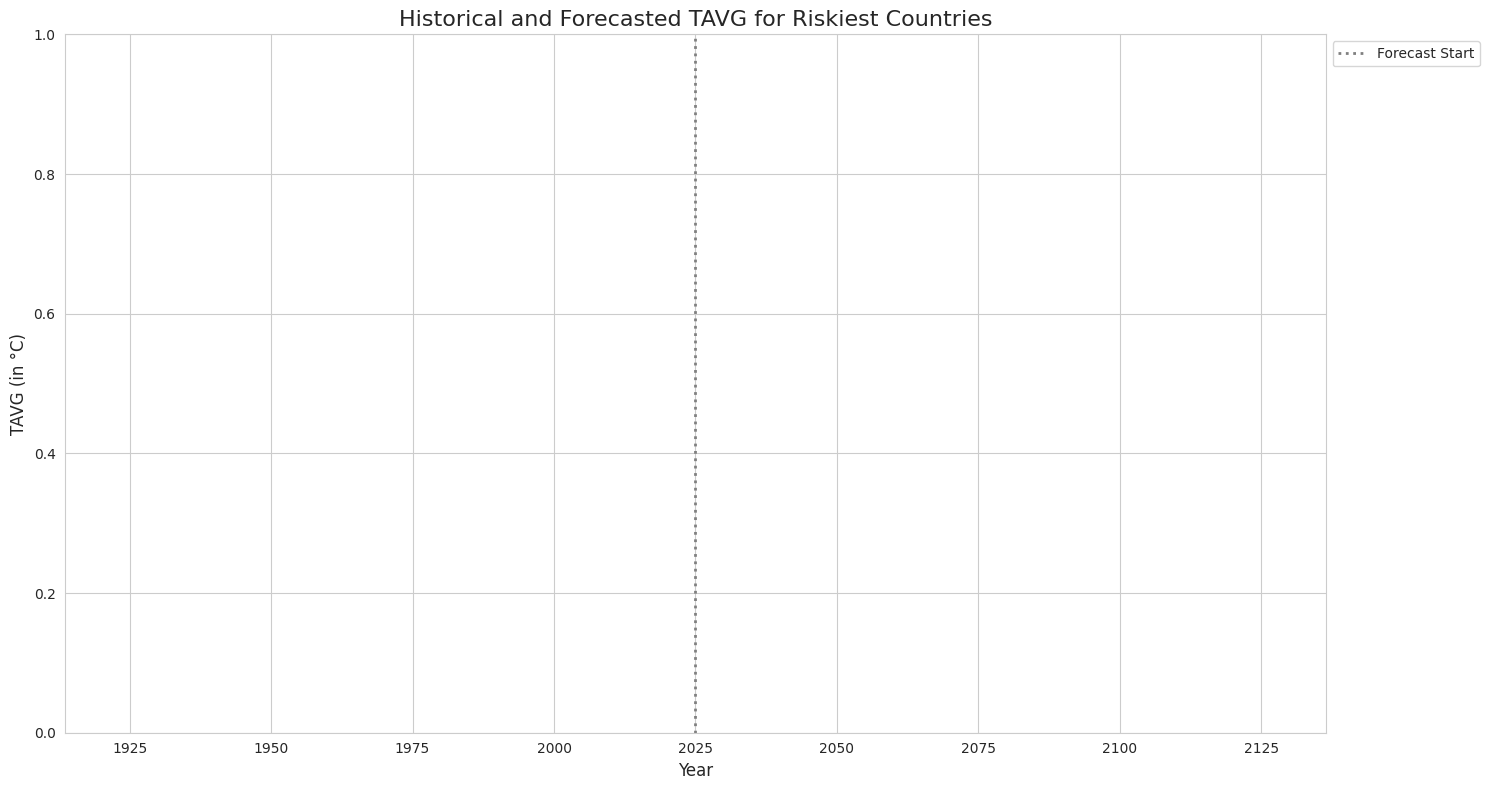

In [ ]:
if __name__ == '__main__':
    data_file_path = f'{basePath}/data/processed/trimmedData.csv'
    arima_orders_final = [(1, 1, 0), (0, 1, 1), (1, 1, 1)]
    columns_to_analyze = ['TAVG'] # ['TMAX', 'TMIN', 'PRCP']

    try:
        df_raw = pd.read_csv(data_file_path)
        print("Raw data loaded successfully.")

        for column_to_analyze in columns_to_analyze:
            print(f"\n--- Starting Full Analysis for COLUMN: {column_to_analyze} ---")

            df_train, df_test = prepare_column_data_pipeline(df_raw, column_name=column_to_analyze)
            df_combined = combine_data_for_final_training(df_train, df_test)

            # last_historical_year = 2025 
            last_historical_year = df_combined['DATE'].max()
            print(f"T")

            final_models_dict = train_final_models(df_combined, column_name=column_to_analyze, arima_orders=arima_orders_final)

            forecasts_dict = forecast_future_values(final_models_dict, df_combined, forecast_years=10, column_name=column_to_analyze)

            df_final = combine_historical_and_forecasts(df_combined, forecasts_dict, column_name=column_to_analyze)

            risky_changes = {}
            for country in df_final['COUNTRY'].unique():
                country_data = df_final[df_final['COUNTRY'] == country].copy()
                historical_data = country_data[country_data['DATE'] <= last_historical_year]
                forecast_data = country_data[country_data['DATE'] > last_historical_year]

                if len(historical_data) >= 10 and len(forecast_data) >= 10:
                    historical_avg = historical_data[column_to_analyze].tail(10).mean()
                    forecast_avg = forecast_data[column_to_analyze].head(10).mean()
                    risk_metric = abs(forecast_avg - historical_avg)
                    risky_changes[country] = risk_metric

            top_n = 5
            riskiest_countries_list = sorted(risky_changes, key=risky_changes.get, reverse=True)[:top_n]

            riskiest_df = pd.DataFrame(list(risky_changes.items()), columns=['COUNTRY', 'RISK_METRIC'])
            riskiest_df = riskiest_df.sort_values(by='RISK_METRIC', ascending=False)

            results_dir = f'{basePath}/reports/final_results'
            os.makedirs(results_dir, exist_ok=True)
            results_path = os.path.join(results_dir, f'{column_to_analyze}_riskiest_countries.csv')
            riskiest_df.to_csv(results_path, index=False)
            print(f"Riskiest countries list saved to {results_path}")

            figure_save_path = f'{basePath}/reports/final_figures/{column_to_analyze}_riskiest_countries.png'
            plot_country_forecasts(df_final, riskiest_countries_list, column_name=column_to_analyze, last_historical_year=last_historical_year, save_path=figure_save_path)

    except Exception as e:
        print(f"\nAn error occurred during the final pipeline run: {e}")

###**Testing Fns -- Debugging (why blank graphs)**

In [ ]:
#1) 
df = pd.read_csv(f"{basePath}/data/processed/trimmedData.csv")

,COUNTRY,DATE,TAVG
25,Antarctica,2021,-10.650000
26,Antarctica,2022,-10.400000
27,Antarctica,2023,-10.600000
28,Australia,2011,20.912821
29,Australia,2012,20.584091
30,Australia,2013,22.139583
31,Australia,2014,22.071739
32,Australia,2015,21.440909
33,Australia,2016,21.243902
34,Australia,2017,21.446512


In [62]:
df_train, df_test = prepare_column_data_pipeline(df, 'TAVG')
df_train.iloc[25:50]
df_test.iloc[25:50] 
"""
we can see that some are till 2025 and some are till 2023..which is not desired...
THis might not be a reason for error...but is increasing the complexity...in other fns..
"""

'\nwe can see that some are till 2025 and some are till 2023..which is not desired...\nTHis might not be a reason for error...but is increasing the complexity...in other fns..\n'

In [ ]:
df_comb = combine_data_for_final_training(df_train, df_test)
#The combined data is not till 2025..some like Antarctica is till 2023

For Antarctica: Start: 1980 and end: 2023


In [68]:
df_comb.iloc[46:96]

,COUNTRY,DATE,TAVG
46,Antarctica,1980,-15.157143
47,Antarctica,1981,-16.050000
48,Antarctica,1982,-15.871429
49,Antarctica,1983,-17.183333
50,Antarctica,1984,-17.350000
51,Antarctica,1985,-15.142857
52,Antarctica,1986,-16.628571
53,Antarctica,1987,-18.650000
54,Antarctica,1988,-15.366667
55,Antarctica,1989,-17.940000
